In [107]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision import datasets, models
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import time
from PIL import Image

device = torch.device('mps' if torch.has_mps else 'cpu')

In [108]:
torch.has_mps

True

In [109]:
print(device)

mps


In [110]:
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((128,128)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
     torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(),
    
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])




# data_transforms = T.Compose([T.Resize(256),
#                             T.CenterCrop(224),
#                             T.ToTensor(),
#                             T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

image_datasets = datasets.ImageFolder('/Users/jiaulhaquesaboj/Documents/Deep-Learning-Project/Garbage Classification', data_transforms)
print(len(image_datasets))

class_names = image_datasets.classes
print(class_names)

15515
['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [111]:
datasets = {}
train_idx, test_idx = train_test_split(list(range(len(image_datasets))), test_size=0.2)
datasets['test'] = torch.utils.data.Subset(image_datasets, test_idx)
train_set = torch.utils.data.Subset(image_datasets, train_idx)
train_idx, val_idx = train_test_split(list(range(len(train_set))), test_size=0.25)
datasets['val'] = torch.utils.data.Subset(image_datasets, val_idx)
datasets['train'] = torch.utils.data.Subset(image_datasets, train_idx)
print(len(datasets['train']), len(datasets['val']), len(datasets['test']))

9309 3103 3103


In [112]:
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], 128, shuffle=True) for x in ['train','val','test']}
x, y = next(iter(dataloaders['train']))
print(x.shape, y.shape)

torch.Size([128, 3, 128, 128]) torch.Size([128])


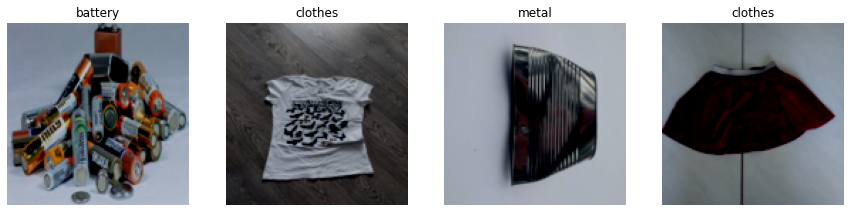

In [113]:
images, labels = next(iter(dataloaders['train']))
plt.figure(figsize=(15,15))
for i in range(4):
    plt.subplot(1, 4, i+1)
    imgs = images[i].numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + std
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    plt.axis('off')
    plt.title(class_names[labels[i]])

In [114]:
def train_model(model, criterion, optimizer, lr_scheduler, epochs=20):
    train_start = time.time()
    history = []
    best_acc = 0.0
    
    for epoch in range(epochs):
        epoch_start = time.time()
        train_loss, train_acc, val_loss, val_acc = 0.0, 0.0, 0.0, 0.0        
        
        model.train()
        for (inputs, labels) in dataloaders['train']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            train_acc += torch.sum(preds == labels.data)
            
        lr_scheduler.step()
            
        with torch.no_grad():
            model.eval()
            
            for (inputs, labels) in dataloaders['val']:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                _, preds = torch.max(outputs, 1)
                val_acc += torch.sum(preds == labels.data)
        
        train_loss /= len(datasets['train'])
        train_acc /= len(datasets['train'])
        val_loss /= len(datasets['val'])
        val_acc /=  len(datasets['val'])
        history.append([train_loss, train_acc, val_loss, val_acc])
        
        print("Epoch : {}, train_loss: {:.4f}, train_acc: {:.4f}, val_loss : {:.4f}, val_acc: {:.4f}, Time: {:.4f}s".format(epoch+1, train_loss, train_acc, val_loss, val_acc, time.time()-epoch_start))
    return model, history

In [115]:
resnet18 = models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.requires_grad = False
    
num_features = resnet18.fc.in_features
resnet18.fc = torch.nn.Linear(num_features, len(class_names))
resnet18 = resnet18.to(device)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(),lr=0.005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)




/Users/jiaulhaquesaboj/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/jiaulhaquesaboj/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [116]:
trained_model, history = train_model(resnet18, loss_func, optimizer, lr_scheduler, epochs=8)

Epoch : 1, train_loss: 0.5647, train_acc: 0.8267, val_loss : 0.3034, val_acc: 0.9065, Time: 63.2236s
Epoch : 2, train_loss: 0.3073, train_acc: 0.8986, val_loss : 0.2635, val_acc: 0.9127, Time: 62.9355s
Epoch : 3, train_loss: 0.2749, train_acc: 0.9100, val_loss : 0.2647, val_acc: 0.9117, Time: 62.4848s
Epoch : 4, train_loss: 0.2532, train_acc: 0.9160, val_loss : 0.2859, val_acc: 0.9040, Time: 63.7897s
Epoch : 5, train_loss: 0.2112, train_acc: 0.9278, val_loss : 0.2662, val_acc: 0.9094, Time: 61.4125s
Epoch : 6, train_loss: 0.1708, train_acc: 0.9421, val_loss : 0.2524, val_acc: 0.9156, Time: 59.8437s
Epoch : 7, train_loss: 0.1640, train_acc: 0.9464, val_loss : 0.2407, val_acc: 0.9227, Time: 64.2300s
Epoch : 8, train_loss: 0.1582, train_acc: 0.9497, val_loss : 0.2457, val_acc: 0.9162, Time: 63.3750s


In [117]:
train_loss = [h[0] for h in history]
train_acc = [h[1].cpu() for h in history]
val_loss = [h[2] for h in history]
val_acc = [h[3].cpu() for h in history]

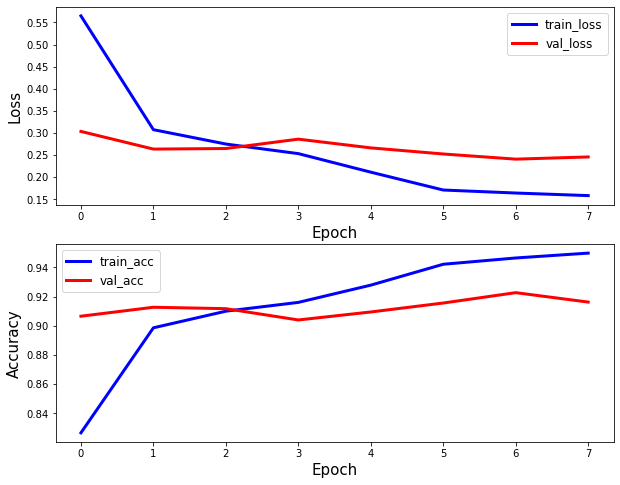

In [118]:
def plot_model_history(history):
    x = np.arange(len(history))
    fig = plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.plot(x, train_loss, label='train_loss', lw=3, c="b")
    plt.plot(x, val_loss, label='val_loss', lw=3, c="r")
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.subplot(2, 1, 2)
    plt.plot(x, train_acc, label='train_acc', lw=3, c="b")
    plt.plot(x, val_acc, label='val_acc', lw=3, c="r")
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Accuracy", fontsize=15)
    plt.show()

plot_model_history(history)

In [119]:
def evaluation_model(model):
    top1 = 0
    top3 = 0
    N = len(datasets['test'])
    for (inputs, labels) in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        outputs = torch.nn.functional.softmax(outputs, dim=-1)
        _, indices = torch.topk(outputs, 3, dim=-1)
        for i in range(len(indices)):
            for j in range(3):
                if indices[i,j] == labels[i]:
                    top3 += 1
                    break
            top1 += 1 if indices[i,0]==labels[i] else 0
    print("Top-1 accuracy: {:.2f}%".format(100*top1/N))
    print("Top-3 accuracy: {:.2f}%".format(100*top3/N))    

In [120]:
evaluation_model(trained_model)

Top-1 accuracy: 82.98%
Top-3 accuracy: 88.91%


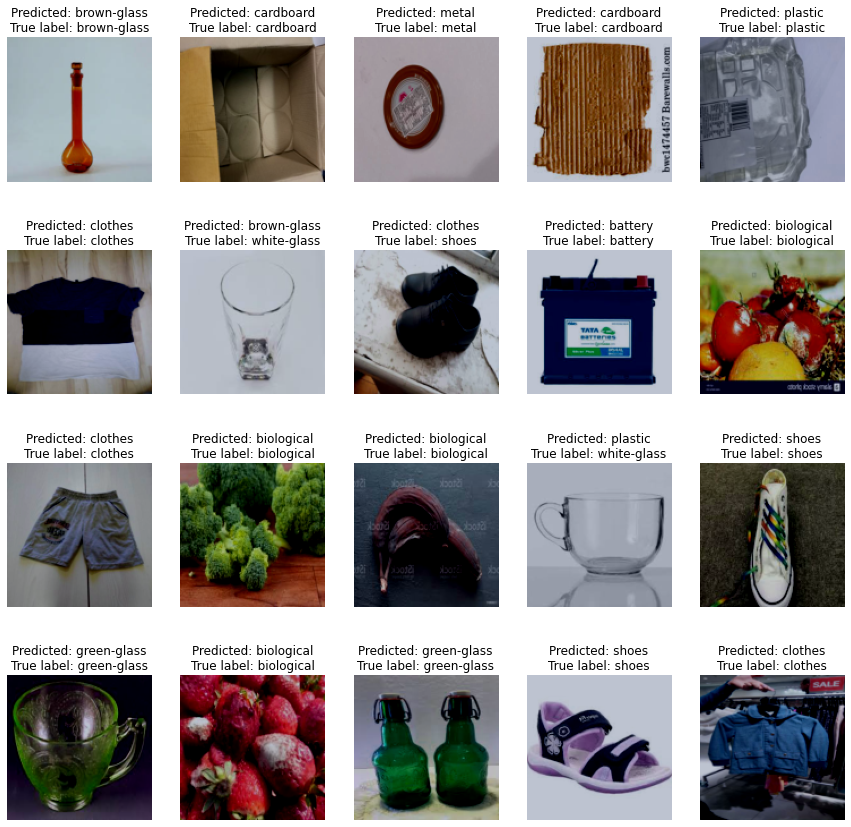

In [121]:
images, labels = next(iter(dataloaders['test']))
images = images.to(device)
outputs = trained_model(images)
_, indices = torch.max(outputs, -1)

plt.figure(figsize=(15,15))
for i in range(20):
    plt.subplot(4, 5, i+1)
    imgs = images[i].cpu().numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = std * imgs + std
    imgs = np.clip(imgs, 0, 1)
    plt.imshow(imgs)
    plt.axis('off')
    title = f"Predicted: {class_names[indices[i]]}\nTrue label: {class_names[labels[i]]}"
    plt.title(title)

In [122]:
# torch.save(trained_model.state_dict(), 'model.pt')